In [2]:
import numpy as np
import jax.numpy as jnp
from interp import *
from utils import timeit
import matplotlib.pyplot as plt
from randgen import *

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".30"

# 1D interpolation

In [2]:
ref_pos = jnp.linspace(-2., 2., 30)
ref_val = jnp.exp(-ref_pos**2/2.)

pos = jnp.linspace(-3., 3., 100)

In [17]:
val = timeit(curve_interpolator)(pos, ref_pos, ref_val)

 Function <curve_interpolator> starts. 
 Function <curve_interpolator> ends! Time cost = 0.000740 sec. 


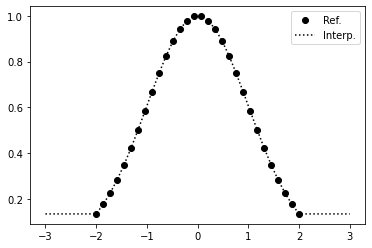

In [22]:
plt.plot(ref_pos, ref_val, color='k', marker='o', ls='', label='Ref.')
plt.plot(pos, val, color='k', ls=':', label='Interp.')
plt.legend()
plt.show()

# 2D interpolation

In [3]:
x = np.random.uniform(-3., 3., 10000)
y = np.random.uniform(-3., 3., 10000)
ref_pos = jnp.array(np.stack([x.ravel(), y.ravel()]).T)
ref_val = jnp.exp(-jnp.sum(ref_pos**2, axis=-1)/2.)

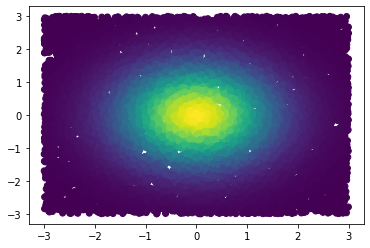

In [81]:
plt.scatter(ref_pos[:, 0], ref_pos[:, 1], c=ref_val)
plt.show()

In [4]:
x = np.linspace(-2., 2., 100)
y = np.linspace(-2., 2., 100)
x, y = np.meshgrid(x, y)
pos = jnp.array(np.stack([x.ravel(), y.ravel()]).T)

In [88]:
val = timeit(map_interpolator_knn)(pos, ref_pos, ref_val)

 Function <map_interpolator_knn> starts. 
 Function <map_interpolator_knn> ends! Time cost = 0.000591 sec. 


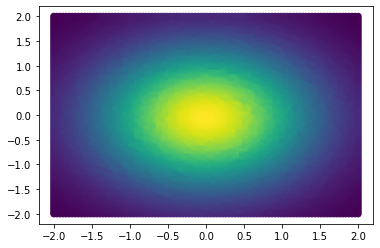

In [89]:
plt.scatter(x.ravel(), y.ravel(), c=val.ravel())
plt.show()

In [ ]:
def map_interpolator_knn_2d(pos, ref_pos_lowers, ref_pos_uppers, ref_val, k=3):
    """
    pos : <jnp.array> with shape (N, 2), as the points to be interpolated.
    ref_pos : <jnp.array> with shape (M, 2), as the reference points.
    ref_val : <jnp.array> with shape (M, ), as the reference values.

    return : interpolated values with shape (N, ), weighted by the inverse of distance to k nearest neighbors. 
    """
    pos = jnp.asarray(pos)
    ref_pos = jnp.asarray(ref_pos)
    ref_val = jnp.asarray(ref_val)
    
    dr2 = -_L2_dist2(pos, ref_pos)
    dr2, ind = lax.top_k(dr2, k)
    weights = 1.0 / jnp.clip(jnp.sqrt(-dr2), 1e-6, float('inf'))
    val = jnp.take(ref_val, ind)
    val = jnp.sum(val * weights, axis=1) / jnp.sum(weights, axis=1)
    
    return val

In [4]:
ref_pos_lowers = jnp.array([-2., -3.])
ref_pos_uppers = jnp.array([2., 3.])

x = np.linspace(ref_pos_lowers[0], ref_pos_uppers[0], 100)
y = np.linspace(ref_pos_lowers[1], ref_pos_uppers[1], 200)
x, y = jnp.meshgrid(x, y)
ref_val = jnp.exp(-(x**2+2*y**2)/2.).T

In [7]:
x = np.linspace(-2., 2., 100)
y = np.linspace(-2., 2., 100)
x, y = np.meshgrid(x, y)
pos = jnp.array(np.stack([x.ravel(), y.ravel()]).T)

In [8]:
num_bins = jnp.asarray(jnp.shape(ref_val))
bin_sizes = (ref_pos_uppers - ref_pos_lowers) / (num_bins - 1)
num_bins = num_bins[jnp.newaxis, :]
bin_sizes = bin_sizes[jnp.newaxis, :]

In [23]:
ind1 = jnp.asarray(jnp.clip(jnp.floor((pos - ref_pos_lowers) / bin_sizes), a_min=0, a_max=num_bins-1), dtype=int)
ind2 = ind1.at[:, 0].add(1)
ind3 = ind1.at[:, 1].add(1)
ind4 = ind2.at[:, 1].add(1)

val1 = ref_val[ind1[:,0], ind1[:,1]]
val2 = ref_val[ind2[:,0], ind2[:,1]]
val3 = ref_val[ind3[:,0], ind3[:,1]]
val4 = ref_val[ind4[:,0], ind4[:,1]]

ref_pos1 = ref_pos_lowers + bin_sizes * ind1
ref_pos2 = ref_pos_lowers + bin_sizes * ind2
ref_pos3 = ref_pos_lowers + bin_sizes * ind3
ref_pos4 = ref_pos_lowers + bin_sizes * ind4

dr1 = jnp.clip(jnp.sqrt(jnp.sum((ref_pos1 - pos)**2, axis=-1)), a_min=1e-10)
dr2 = jnp.clip(jnp.sqrt(jnp.sum((ref_pos2 - pos)**2, axis=-1)), a_min=1e-10)
dr3 = jnp.clip(jnp.sqrt(jnp.sum((ref_pos3 - pos)**2, axis=-1)), a_min=1e-10)
dr4 = jnp.clip(jnp.sqrt(jnp.sum((ref_pos4 - pos)**2, axis=-1)), a_min=1e-10)

val = (val1/dr1+val2/dr2+val3/dr3+val4/dr4) / (1./dr1+1./dr2+1./dr3+1./dr4)

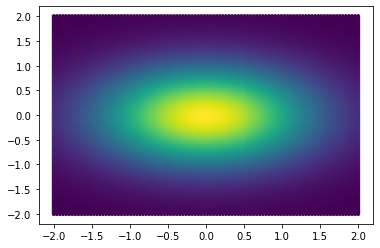

In [28]:
plt.scatter(pos[:, 0], pos[:, 1], s=10, c=val)

In [63]:
test = jnp.array([
    [0, 1],
    [10, 11],
    [20, 21],
    [30, 31],
    [40, 41]
])

In [67]:
test[[0,1,2, 2, 2], [0, 1, 1, 0,0]]

DeviceArray([ 0, 11, 21, 20, 20], dtype=int32)

In [62]:
ind1

DeviceArray([[  0,  24],
             [  1,  24],
             [  1,  24],
             ...,
             [ 97, 124],
             [ 98, 124],
             [ 99, 124]], dtype=int32)

In [61]:
ref_val[tuple(ind1)].shape

IndexError: Too many indices for array: 10000 non-None/Ellipsis indices for dim 2.

In [51]:
ind1

DeviceArray([[  0,  24],
             [  1,  24],
             [  1,  24],
             ...,
             [ 97, 124],
             [ 98, 124],
             [ 99, 124]], dtype=int32)

In [52]:
ind2

DeviceArray([[  1,  24],
             [  2,  24],
             [  2,  24],
             ...,
             [ 98, 124],
             [ 99, 124],
             [100, 124]], dtype=int32)

In [53]:
ind3

DeviceArray([[  0,  25],
             [  1,  25],
             [  1,  25],
             ...,
             [ 97, 125],
             [ 98, 125],
             [ 99, 125]], dtype=int32)

In [54]:
ind4

DeviceArray([[  1,  25],
             [  2,  25],
             [  2,  25],
             ...,
             [ 98, 125],
             [ 99, 125],
             [100, 125]], dtype=int32)